# Token Embeddings & Positional Encoding

## The First Problem: Computers Don't Understand Words

Here's our challenge: neural networks operate on numbers—specifically, vectors of floating-point numbers. But language is made of words. How do we bridge this gap?

The naive approach might be to assign each word a number: "cat" = 1, "dog" = 2, "the" = 3, etc. But this creates false relationships. Is "cat" more similar to "dog" than to "the" because 1 is closer to 2 than to 3? Of course not. These numbers are arbitrary.

We need representations where:
- Similar words have similar representations
- The representation captures meaningful features
- We can do math on them (add, multiply, compare)

The solution is **embeddings**: learned vector representations for each token.

## What Is a Token?

Before embedding, we need to **tokenize**—break text into pieces called tokens. Different tokenizers make different choices:

| Approach | "unhappiness" becomes | Trade-off |
|----------|----------------------|------------|
| Character | `['u','n','h','a','p','p','i','n','e','s','s']` | Very long sequences |
| Word | `['unhappiness']` | Huge vocabulary, can't handle rare words |
| Subword (BPE) | `['un', 'happiness']` | Balanced: captures morphology, handles rare words |

Modern LLMs use **subword tokenization** (like Byte-Pair Encoding or SentencePiece). The tokenizer learns common character sequences from data. "unhappiness" becomes `['un', 'happiness']` because those are common patterns. A rare word like "defenestration" might become `['def', 'en', 'est', 'ration']`.

For this notebook, we'll assume tokenization is already done. We receive token IDs (integers) and need to convert them to vectors.

## Token Embeddings: A Learned Lookup Table

An embedding is deceptively simple: it's a lookup table. We have a matrix $E \in \mathbb{R}^{|V| \times d_{model}}$ where:
- $|V|$ is the vocabulary size (number of unique tokens)
- $d_{model}$ is the embedding dimension

To embed token ID $i$, we just retrieve row $i$ of the matrix:

$$\text{embed}(i) = E[i] \in \mathbb{R}^{d_{model}}$$

That's it. No activation functions, no complicated math. Just a lookup.

The magic is that these vectors are **learned**. During training, backpropagation adjusts the embedding matrix so that:
- Semantically similar tokens get similar vectors
- The vectors contain information useful for the task

After training on enough text, you find that `embed("king") - embed("man") + embed("woman") ≈ embed("queen")`. The geometry of the embedding space captures meaning.

In [1]:
import torch
import torch.nn as nn
import math

class TokenEmbedding(nn.Module):
    """
    Convert token indices to dense vectors.
    
    This is simply a learned lookup table: each token ID maps to a d_model-dimensional vector.
    """
    
    def __init__(self, vocab_size: int, d_model: int):
        super().__init__()
        # The embedding matrix: [vocab_size, d_model]
        # PyTorch's nn.Embedding handles the lookup efficiently
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model
    
    def forward(self, token_ids: torch.Tensor) -> torch.Tensor:
        """
        Args:
            token_ids: (batch_size, seq_len) - integer token IDs
        
        Returns:
            embeddings: (batch_size, seq_len, d_model) - dense vectors
        """
        return self.embedding(token_ids)

In [2]:
# Let's see it in action
vocab_size = 10000
d_model = 256

embed = TokenEmbedding(vocab_size, d_model)

# Simulate a batch of tokenized text
# batch_size=2, seq_len=5
token_ids = torch.tensor([
    [101, 2054, 2003, 2115, 2171],  # "What is your name"
    [101, 1045, 2066, 2653, 102],   # "I like pizza"
])

embeddings = embed(token_ids)

print(f"Input token IDs shape: {token_ids.shape}")
print(f"Output embeddings shape: {embeddings.shape}")
print(f"\nEach token is now a {d_model}-dimensional vector.")
print(f"\nFirst token (ID {token_ids[0, 0].item()}) embedding (first 8 dims):")
print(f"  {embeddings[0, 0, :8].detach().numpy().round(4)}")

Input token IDs shape: torch.Size([2, 5])
Output embeddings shape: torch.Size([2, 5, 256])

Each token is now a 256-dimensional vector.

First token (ID 101) embedding (first 8 dims):
  [-0.5929 -0.9006 -0.3258  0.2935  0.5124 -0.5149  1.5929 -0.6648]


## The Position Problem

Now we hit a subtle but critical issue.

Consider these two sentences:
- "The cat ate the mouse"
- "The mouse ate the cat"

Same words. Completely different meanings. **Word order matters.**

But look at our embedding: `embed("cat")` returns the same vector regardless of where "cat" appears in the sentence. The embedding has no concept of position.

RNNs solved this naturally—they process sequentially, so position is implicit in the order of processing. But transformers process all positions in parallel. When computing attention, position 3 doesn't "know" it comes after position 2.

We need to inject positional information somehow. There are three main approaches:

| Method | How It Works | Used By | Trade-offs |
|--------|--------------|---------|------------|
| **Learned** | Add a learned vector per position | GPT-2, BERT | Simple; limited to training context length |
| **ALiBi** | Add distance-based penalty to attention | BLOOM, MPT | No extra params; excellent extrapolation |
| **RoPE** | Rotate Q and K by position-dependent angle | LLaMA, Mistral | No extra params; good extrapolation |

Let's implement all three.

## Approach 1: Learned Positional Embeddings

The simplest approach: learn a separate embedding for each position, just like we learn embeddings for each token.

We have a position embedding matrix $P \in \mathbb{R}^{n_{ctx} \times d_{model}}$ where $n_{ctx}$ is the maximum sequence length. To get the input to the transformer:

$$\text{input}_i = E[\text{token}_i] + P[i]$$

We simply **add** the position embedding to the token embedding. This gives each position a unique "signature" that the model can learn to recognize.

**Why addition?** It's elegant and works well in practice. You could concatenate instead (doubling the dimension), but addition keeps the dimension fixed and lets position information "blend" with token information.

In [3]:
class LearnedPositionalEmbedding(nn.Module):
    """
    Learned positional embeddings (GPT-2 / BERT style).
    
    Each position 0, 1, 2, ... gets its own learned d_model-dimensional vector.
    These are added to the token embeddings to inject position information.
    """
    
    def __init__(self, d_model: int, max_seq_len: int = 512):
        super().__init__()
        # Position embedding matrix: [max_seq_len, d_model]
        self.pos_embedding = nn.Embedding(max_seq_len, d_model)
        self.max_seq_len = max_seq_len
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch_size, seq_len, d_model) - token embeddings
        
        Returns:
            (batch_size, seq_len, d_model) - embeddings with position info added
        """
        batch_size, seq_len, d_model = x.shape
        
        # Create position indices: [0, 1, 2, ..., seq_len-1]
        positions = torch.arange(seq_len, device=x.device)
        
        # Look up position embeddings: (seq_len, d_model)
        pos_emb = self.pos_embedding(positions)
        
        # Add to input (broadcasting handles batch dimension)
        return x + pos_emb

In [4]:
# Example
pos_embed = LearnedPositionalEmbedding(d_model=256, max_seq_len=512)

# Token embeddings (from before)
x = torch.randn(2, 10, 256)  # batch=2, seq_len=10, d_model=256

# Add position information
x_with_pos = pos_embed(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {x_with_pos.shape}")
print(f"\nPosition embedding for position 0 (first 8 dims):")
print(f"  {pos_embed.pos_embedding.weight[0, :8].detach().numpy().round(4)}")
print(f"\nPosition embedding for position 1 (first 8 dims):")
print(f"  {pos_embed.pos_embedding.weight[1, :8].detach().numpy().round(4)}")

# Count parameters
n_params = sum(p.numel() for p in pos_embed.parameters())
print(f"\nPosition embedding parameters: {n_params:,} ({n_params/1e6:.2f}M)")

Input shape: torch.Size([2, 10, 256])
Output shape: torch.Size([2, 10, 256])

Position embedding for position 0 (first 8 dims):
  [-0.3798 -0.213  -0.0125  1.3712  0.3764  0.7317  0.6994  0.5426]

Position embedding for position 1 (first 8 dims):
  [-1.2515  0.3716 -0.0856  0.4008 -1.6826  0.8241  0.4761 -1.3326]

Position embedding parameters: 131,072 (0.13M)


### Limitation: Fixed Context Length

The problem with learned positions: you can only handle positions you've seen during training. If you trained with `max_seq_len=512`, you have no embedding for position 513. The model breaks on longer sequences.

Some models try to fix this with position interpolation (stretching the learned positions), but it's hacky. Better approaches encode position differently...

## Approach 2: ALiBi (Attention with Linear Biases)

ALiBi takes a completely different approach: instead of modifying embeddings, it modifies **attention scores** directly.

The key insight: what matters for language isn't absolute position ("this is position 17") but **relative position** ("these words are 3 positions apart"). Nearby words are usually more relevant than distant ones.

ALiBi adds a penalty to attention scores based on distance:

$$\text{attention\_score}_{i,j} = \frac{Q_i \cdot K_j}{\sqrt{d_k}} - m \cdot |i - j|$$

Where $m$ is a learned or fixed "slope" that controls how fast attention decays with distance.

**The further apart two positions are, the more negative the penalty, the less attention.**

This is beautifully simple:
- **Zero parameters** to learn
- **Extrapolates naturally** to longer sequences (the penalty formula works for any distance)
- **Different slopes per head** let some heads focus locally, others globally

In [5]:
class ALiBiPositionalBias(nn.Module):
    """
    ALiBi: Attention with Linear Biases.
    
    Instead of adding position info to embeddings, we add a distance-based
    penalty directly to attention scores. Different heads use different
    slopes, letting some focus locally and others globally.
    
    Reference: https://arxiv.org/abs/2108.12409
    """
    
    def __init__(self, num_heads: int):
        super().__init__()
        
        # Slopes form a geometric sequence: 2^(-8/n), 2^(-16/n), ...
        # Head 0 has the steepest slope (strongest local focus)
        # Last head has the gentlest slope (most global)
        slopes = torch.tensor([
            2 ** (-8 * (i + 1) / num_heads) 
            for i in range(num_heads)
        ])
        # Register as buffer (not a parameter - we don't learn it)
        self.register_buffer('slopes', slopes)
        self.num_heads = num_heads
    
    def forward(self, seq_len: int) -> torch.Tensor:
        """
        Compute ALiBi bias matrix.
        
        Args:
            seq_len: length of the sequence
        
        Returns:
            bias: (num_heads, seq_len, seq_len) - add this to attention scores
        """
        # Position indices
        positions = torch.arange(seq_len, device=self.slopes.device)
        
        # Compute pairwise distances: |i - j|
        # positions.unsqueeze(0) is [1, seq_len]
        # positions.unsqueeze(1) is [seq_len, 1]
        # Broadcasting gives [seq_len, seq_len]
        distances = torch.abs(positions.unsqueeze(0) - positions.unsqueeze(1))
        
        # Apply slopes: -slope * distance
        # slopes is [num_heads], distances is [seq_len, seq_len]
        # Result is [num_heads, seq_len, seq_len]
        biases = -self.slopes.view(-1, 1, 1) * distances.unsqueeze(0).float()
        
        return biases

In [6]:
# Let's see the ALiBi biases
alibi = ALiBiPositionalBias(num_heads=4)
biases = alibi(seq_len=6)

print(f"ALiBi bias shape: {biases.shape}")
print(f"Slopes per head: {alibi.slopes.numpy().round(4)}")
print()

# Head 0: steepest slope (strongest local preference)
print("Head 0 biases (steep slope - prefers nearby tokens):")
print(biases[0].numpy().round(3))
print()

# Head 3: gentlest slope (most global)
print("Head 3 biases (gentle slope - more global attention):")
print(biases[3].numpy().round(3))

ALiBi bias shape: torch.Size([4, 6, 6])
Slopes per head: [0.25   0.0625 0.0156 0.0039]

Head 0 biases (steep slope - prefers nearby tokens):
[[-0.   -0.25 -0.5  -0.75 -1.   -1.25]
 [-0.25 -0.   -0.25 -0.5  -0.75 -1.  ]
 [-0.5  -0.25 -0.   -0.25 -0.5  -0.75]
 [-0.75 -0.5  -0.25 -0.   -0.25 -0.5 ]
 [-1.   -0.75 -0.5  -0.25 -0.   -0.25]
 [-1.25 -1.   -0.75 -0.5  -0.25 -0.  ]]

Head 3 biases (gentle slope - more global attention):
[[-0.    -0.004 -0.008 -0.012 -0.016 -0.02 ]
 [-0.004 -0.    -0.004 -0.008 -0.012 -0.016]
 [-0.008 -0.004 -0.    -0.004 -0.008 -0.012]
 [-0.012 -0.008 -0.004 -0.    -0.004 -0.008]
 [-0.016 -0.012 -0.008 -0.004 -0.    -0.004]
 [-0.02  -0.016 -0.012 -0.008 -0.004 -0.   ]]


### Interpreting the Bias Matrix

Look at the diagonal: it's always 0 (distance to self is 0). Moving away from the diagonal, values become more negative.

For Head 0 with slope ~0.25:
- Distance 1: penalty = -0.25
- Distance 2: penalty = -0.50
- Distance 5: penalty = -1.25

For Head 3 with slope ~0.016:
- Distance 1: penalty = -0.016
- Distance 5: penalty = -0.08

Head 0 strongly prefers nearby tokens. Head 3 barely distinguishes distances—it can attend globally. This specialization emerges naturally from the geometric slope sequence.

## Approach 3: RoPE (Rotary Position Embeddings)

RoPE is the most mathematically elegant approach. Instead of adding position information, it **rotates** the query and key vectors.

The core insight: if we rotate Q and K by angles that depend on their positions, then their dot product naturally encodes relative position.

**The math (simplified):**

For a 2D vector $(x_1, x_2)$ at position $m$, we rotate by angle $m\theta$:

$$\begin{pmatrix} x_1' \\ x_2' \end{pmatrix} = \begin{pmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$$

In higher dimensions, we pair up dimensions and rotate each pair by a different frequency. The key property:

$$Q_m^T K_n = f(Q, K, m-n)$$

The dot product depends only on the **relative position** $m - n$, not the absolute positions. Beautiful.

In [7]:
class RotaryPositionalEmbedding(nn.Module):
    """
    RoPE: Rotary Position Embeddings.
    
    Rotates query and key vectors by position-dependent angles.
    The dot product Q·K then naturally encodes relative position.
    
    Reference: https://arxiv.org/abs/2104.09864
    """
    
    def __init__(self, d_model: int, max_seq_len: int = 5000, base: int = 10000):
        super().__init__()
        
        # Compute inverse frequencies for each dimension pair
        # These determine the rotation speed for each pair
        # Lower dimensions rotate faster (higher frequency)
        inv_freq = 1.0 / (base ** (torch.arange(0, d_model, 2).float() / d_model))
        self.register_buffer('inv_freq', inv_freq)
        
        # Precompute cos/sin for all positions
        self._build_cache(max_seq_len)
    
    def _build_cache(self, seq_len: int):
        """Precompute rotation matrices for efficiency."""
        positions = torch.arange(seq_len, device=self.inv_freq.device)
        
        # Outer product: positions × frequencies
        # Shape: [seq_len, d_model/2]
        freqs = torch.outer(positions.float(), self.inv_freq)
        
        # Cache cos and sin
        self.register_buffer('cos_cached', freqs.cos(), persistent=False)
        self.register_buffer('sin_cached', freqs.sin(), persistent=False)
    
    def forward(self, seq_len: int):
        """
        Get rotation matrices for the given sequence length.
        
        Returns:
            cos: (seq_len, d_model/2)
            sin: (seq_len, d_model/2)
        """
        return self.cos_cached[:seq_len], self.sin_cached[:seq_len]


def apply_rotary_emb(x: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor) -> torch.Tensor:
    """
    Apply rotary embeddings to input tensor.
    
    Args:
        x: (batch, seq_len, d_model) or (batch, n_heads, seq_len, d_k)
        cos: (seq_len, d_model/2)
        sin: (seq_len, d_model/2)
    
    Returns:
        Rotated tensor with same shape as x
    """
    # Split into even and odd dimensions
    x1 = x[..., 0::2]  # Even indices
    x2 = x[..., 1::2]  # Odd indices
    
    # Apply rotation
    # [x1, x2] → [x1*cos - x2*sin, x1*sin + x2*cos]
    x_rotated = torch.stack([
        x1 * cos - x2 * sin,
        x1 * sin + x2 * cos
    ], dim=-1).flatten(-2)
    
    return x_rotated

In [8]:
# Example
d_model = 64
rope = RotaryPositionalEmbedding(d_model=d_model, max_seq_len=512)

cos, sin = rope(seq_len=10)

print(f"Cos cache shape: {cos.shape}")
print(f"Sin cache shape: {sin.shape}")
print()
print("Frequencies (inverse) for first 4 dimension pairs:")
print(f"  {rope.inv_freq[:4].numpy().round(4)}")
print()
print("Notice: lower dimensions have higher frequencies (rotate faster).")
print("This lets the model capture both local (fast) and global (slow) patterns.")

Cos cache shape: torch.Size([10, 32])
Sin cache shape: torch.Size([10, 32])

Frequencies (inverse) for first 4 dimension pairs:
  [1.     0.7499 0.5623 0.4217]

Notice: lower dimensions have higher frequencies (rotate faster).
This lets the model capture both local (fast) and global (slow) patterns.


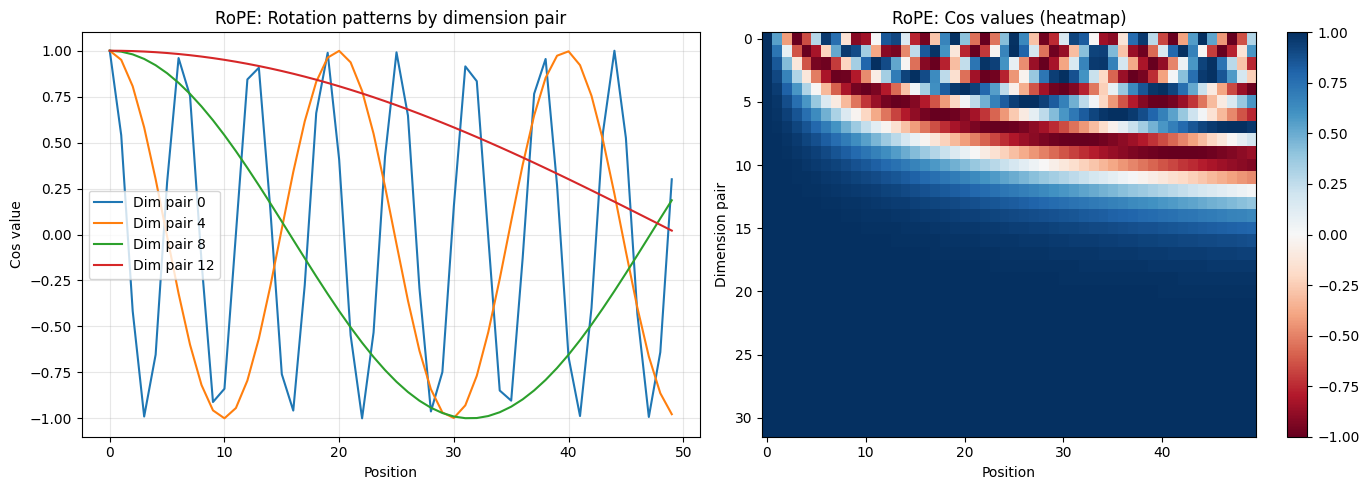

Low dimension pairs (top of heatmap) oscillate rapidly.
High dimension pairs (bottom) change slowly across positions.


In [9]:
# Visualize the rotation frequencies
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: show cos values across positions for different frequency pairs
ax = axes[0]
positions = np.arange(50)
cos_np = rope.cos_cached[:50].numpy()

for i in [0, 4, 8, 12]:  # Different frequency indices
    ax.plot(positions, cos_np[:, i], label=f'Dim pair {i}')

ax.set_xlabel('Position')
ax.set_ylabel('Cos value')
ax.set_title('RoPE: Rotation patterns by dimension pair')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: show the full cos cache as a heatmap
ax = axes[1]
im = ax.imshow(cos_np.T, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
ax.set_xlabel('Position')
ax.set_ylabel('Dimension pair')
ax.set_title('RoPE: Cos values (heatmap)')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("Low dimension pairs (top of heatmap) oscillate rapidly.")
print("High dimension pairs (bottom) change slowly across positions.")

## Comparison: Which Approach to Use?

| Property | Learned | ALiBi | RoPE |
|----------|---------|-------|------|
| **Parameters** | $n_{ctx} \times d_{model}$ | 0 | 0 |
| **Position type** | Absolute | Relative | Relative |
| **Extrapolation** | Poor | Excellent | Very good |
| **Implementation** | Simplest | Moderate | Complex |
| **Used by** | GPT-2, BERT | BLOOM, MPT | LLaMA, Mistral, Qwen |

**Recommendations:**
- **Learned**: Fine for fixed-length tasks, easy to understand
- **ALiBi**: Great for extrapolation, trivial to implement, very efficient
- **RoPE**: The current favorite for LLMs; best balance of quality and extrapolation

For this tutorial, we'll use **learned positions** for simplicity—the concepts are clearer. But modern production models almost always use RoPE.

## Putting It Together: The Embedding Module

Here's a complete embedding module that combines token embeddings with learned positions:

In [10]:
class TransformerEmbedding(nn.Module):
    """
    Complete embedding module: token embeddings + positional encoding.
    
    Converts token IDs to dense vectors with position information.
    """
    
    def __init__(self, vocab_size: int, d_model: int, max_seq_len: int, dropout: float = 0.1):
        super().__init__()
        
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_seq_len, d_model)
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
    
    def forward(self, token_ids: torch.Tensor) -> torch.Tensor:
        """
        Args:
            token_ids: (batch_size, seq_len) - integer token IDs
        
        Returns:
            (batch_size, seq_len, d_model) - embedded tokens with positions
        """
        batch_size, seq_len = token_ids.shape
        
        # Token embeddings: (batch, seq_len, d_model)
        tok_emb = self.token_embedding(token_ids)
        
        # Position embeddings: (seq_len, d_model)
        positions = torch.arange(seq_len, device=token_ids.device)
        pos_emb = self.pos_embedding(positions)
        
        # Combine and apply dropout
        x = tok_emb + pos_emb
        x = self.dropout(x)
        
        return x

In [11]:
# Create embedding module with our config
embedding = TransformerEmbedding(
    vocab_size=10000,
    d_model=256,
    max_seq_len=512,
    dropout=0.1
)

# Test it
token_ids = torch.randint(0, 10000, (4, 32))  # batch=4, seq_len=32
embeddings = embedding(token_ids)

print(f"Input tokens: {token_ids.shape}")
print(f"Output embeddings: {embeddings.shape}")

# Count parameters
n_params = sum(p.numel() for p in embedding.parameters())
print(f"\nEmbedding parameters: {n_params:,}")
print(f"  Token embeddings: {10000 * 256:,}")
print(f"  Position embeddings: {512 * 256:,}")

Input tokens: torch.Size([4, 32])
Output embeddings: torch.Size([4, 32, 256])

Embedding parameters: 2,691,072
  Token embeddings: 2,560,000
  Position embeddings: 131,072


## What We've Built

We now have the first stage of the transformer:

```
Token IDs: [101, 2054, 2003, 2115, 2171]
              ↓
Token Embedding (lookup table)
              ↓
Vectors: [[0.1, -0.3, ...], [0.5, 0.2, ...], ...]
              ↓
Position Embedding (add position vectors)
              ↓
Position-aware vectors: [[0.2, -0.1, ...], [0.6, 0.4, ...], ...]
```

Each token is now represented as a $d_{model}$-dimensional vector that encodes both:
- **What** the token is (from the token embedding)
- **Where** it appears in the sequence (from the position embedding)

These vectors are the input to the transformer blocks. In the next notebook, we'll see how tokens use attention to "talk" to each other.

## Key Takeaways

1. **Embeddings are learned lookup tables** that convert discrete token IDs to continuous vectors

2. **Transformers need position information** because they process all positions in parallel (unlike RNNs)

3. **Three approaches to position encoding:**
   - Learned: simple, but limited extrapolation
   - ALiBi: zero parameters, modifies attention scores
   - RoPE: zero parameters, rotates Q and K vectors

4. **Modern models prefer relative position** (ALiBi, RoPE) over absolute (learned)

## Next: Attention

We have vectors for each token. Now comes the magic: the attention mechanism that lets tokens gather information from each other.

In the next notebook, we'll implement scaled dot-product attention from scratch—the Q, K, V projections, the softmax, the causal mask. This is the heart of the transformer.